In [1]:
import cv2
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [77]:
datafile = "SimulatorData/video3.csv"
tailfile = "SimulatorData/video3.mat"
videofile = "SimulatorData/video3.mp4"

num_sperm = 25
image_shape = (500,500,3)
head_size = 4

heads = pd.read_csv(datafile, index_col=False).values
tails = loadmat(tailfile)["Tail_history"]

#Reshape tails to separate each sperm
tails = tails.reshape(25, tails.shape[0]//num_sperm, tails.shape[1],tails.shape[2])

print(heads)
print(tails)
print(tails.shape)

c:\Users\hartda23\.conda\envs\pytorch23\Lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


[[  2.    332.97  123.71  ...   1.      0.      0.   ]
 [  3.     94.401 147.98  ...   1.      0.      0.   ]
 [  4.     64.008 308.55  ...   1.      0.      0.   ]
 ...
 [ 23.    294.75   47.115 ... 900.      3.      0.   ]
 [ 24.    113.09  299.26  ... 900.      3.      0.   ]
 [ 25.    192.31  235.46  ... 900.      3.      0.   ]]
[[[[350.66370844 347.52252782 344.35370788 ... 292.32355879
    292.05368626 291.99671953]
   [297.7112593  297.33962035 296.85986783 ... 156.64968565
    159.24406382 162.3943649 ]]

  [[350.91232301 347.82243046 344.64316625 ... 292.42468243
    292.10336173 292.03794494]
   [297.67032084 297.34730121 296.90288439 ... 156.61783215
    159.14333788 162.26060677]]

  [[351.15310511 348.11897357 344.93509658 ... 292.53251073
    292.15732809 292.07913807]
   [297.62647445 297.35207639 296.9435572  ... 156.59260972
    159.04718276 162.12803987]]

  ...

  [[388.1097168  387.2781436  386.4640425  ... 326.82118076
    325.89600039 324.96303993]
   [298.158177

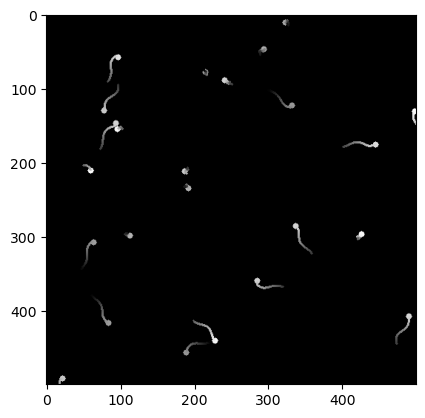

In [78]:
num_sperm, num_points, _, num_frames = tails.shape
import matplotlib.pyplot as plt

# Cell index, x, y, angle, frame, type, flag

images = []
segmentations = []
final = pd.DataFrame(columns=["x", "y", "sperm", "frame", "segmentation"])

intensity = np.random.randint(150, 255, num_sperm)

for frame in range(0,num_frames):
    
    image = np.zeros(image_shape).astype(np.uint8)
    segs = []
    
    for sperm in range(0,num_sperm):
        tail_points = tails[sperm,:,:,frame]
        # Match at the 5th column
        head_vals = heads[heads[:,4] == frame+1]
        head_vals = head_vals[head_vals[:,0] == sperm+1]

        if head_vals.shape[0] == 0:
            continue
        elif head_vals.shape[0] > 1:
            print("Multiple heads")

        # Grab the x,y,angle values
        x,y,angle = head_vals[0,1:4]
    
        buffer = np.zeros(image_shape).astype(np.uint8)
        segments = np.zeros(image_shape).astype(np.uint8)

        it = int(intensity[sperm])
        #print(it)

        # Draw the head
        #cv2.ellipse(image, (int(x), int(y)), (int(1.5*np.sqrt(head_size)), int(np.sqrt(head_size))), angle, 0, 360, (255, 255, 255), -1)
        cv2.circle(buffer, (int(x), int(y)), head_size, (it, it, it), -1)
        cv2.circle(segments, (int(x), int(y)), head_size, (255, 255, 255), -1)

        # Draw the tail
        for i in range(0,num_points):
            xt,yt = tail_points[i]
            cv2.circle(buffer, (int(xt), int(yt)), 1, (it, it, it), -1)
            cv2.circle(segments, (int(xt), int(yt)), 1, (255, 255, 255), -1)
            # Drop off intensity as the tail gets further from the head
            if i % 2 == 0:
                it -= 1
                it = max(it, 1)

        # Save segmentations as list of indices
        locs = np.where(segments[:,:,0] == 255)
        seg = np.array((locs[0], locs[1])).T
        segs.append(seg)

        #print(seg.dtype)
        #print(seg.tolist())

        # Save to final data
        #final = final.append({"x": x, "y": y, "sperm": sperm, "frame": frame, "segmentation": seg}, ignore_index=True)
        if final.shape[0] == 0:
            final = pd.DataFrame({"x": x, "y": y, "sperm": sperm, "frame": frame, "segmentation": str(seg.tolist())}, index=[0])
        else:
            final = pd.concat([final, pd.DataFrame({"x": x, "y": y, "sperm": sperm, "frame": frame, "segmentation": str(seg.tolist())}, index=[0])], ignore_index=True)

        # Blur the image
        # buffer = cv2.GaussianBlur(buffer, (3,3), 0)

        # Add to image, prevent overflow at crossovers
        image = np.maximum(np.maximum(image, image+buffer), buffer)

    segmentations.append(segs)
    images.append(image)

plt.imshow(images[0])
plt.show()

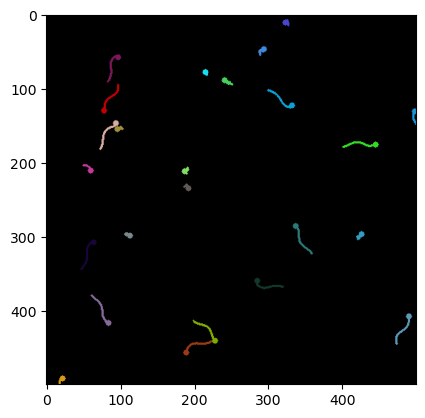

In [79]:
canvas = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)
for seg in segmentations[0]:
    #print(seg.shape)
    canvas[seg[:,0], seg[:,1], :] = np.random.randint(0, 255, 3)

plt.imshow(canvas)
plt.show()    

In [80]:
# Save the images as video
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('output.mp4', fourcc, 60.0, (image_shape[1], image_shape[0]))

print(len(images))

for i in range(0,len(images)):
    out.write(images[i])

out.release()

900


In [81]:
# Save output data
final.to_csv("output.csv", index=False)

In [82]:
import visualizer
import utils
import importlib

importlib.reload(visualizer)

# Load the video
outvideofile = "output.mp4"

# Test Loader of CSV
outdata = utils.loadDataFrame("output.csv",convert_segmentation=True)

visualizer.runVisualization(outvideofile, outdata, visualization="segments", savefile="output_segments.mp4")

Converting segmentations to list...
Done.
(25, 3)
Video Finished.
